In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Filtering out Duplicates and Highly Similar Rows

In [ ]:
import pandas as pd
df = pd.read_csv('drive/MyDrive/biased.full', sep='\t', names=["id", "src_tok", "tgt_tok", "src_raw", "tgt_raw", "src_POS_tags", "tgt_parse_tags"], on_bad_lines='skip')
df = df.drop_duplicates(subset='src_raw')
df = df.drop_duplicates(subset='src_tok')
df = df.drop_duplicates(subset='tgt_raw')
df = df.drop_duplicates(subset='tgt_tok')
df = df.reset_index(drop=True)

In [ ]:
df.shape

(179452, 7)

In [ ]:
dfsample = df[:10000]

In [ ]:
#sparse for samples
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(dfsample['src_raw'])
cosine_sim_sparse = cosine_similarity(tfidf_matrix)

import numpy as np
threshold=0.7

mask = np.tril(np.ones(cosine_sim_sparse.shape)).astype(bool)

# Set the lower triangle elements to zero
cosine_sim_sparse[mask] = 0

similar_indices = np.where(cosine_sim_sparse >= threshold)

to_drop = set(similar_indices[0])
filtered_df = dfsample.drop(index=list(to_drop))

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

# Step 1: Compute TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['src_raw'])

threshold = 0.7
block_size = 5000  # Define the block size (in the example, 5)

def blockwise_cosine_similarity(matrix, block_size=5):
    n = matrix.shape[0]
    to_drop = set()

    for block_idx, start_idx in enumerate(range(0, n, block_size)):
        end_idx = min(start_idx + block_size, n)

        # Compute cosine similarity for the current block against the whole matrix
        block = matrix[start_idx:end_idx]
        block_similarities = cosine_similarity(block, matrix)  # Full comparison

        # Create a mask to block the diagonal and lower triangle for the current block
        # And also mask previous blocks
        mask = np.zeros_like(block_similarities, dtype=bool)

        # Mask lower triangle within the block
        block_size_actual = end_idx - start_idx
        block_mask = np.tril(np.ones((block_size_actual, block_size_actual)), k=0).astype(bool)
        mask[:block_size_actual, start_idx:end_idx] = block_mask

        # Mask the rows of the current block compared to the previous blocks (rows below diagonal in previous blocks)
        if start_idx > 0:
            mask[:, :start_idx] = True  # Mask all comparisons with earlier blocks

        # Apply the mask
        block_similarities[mask] = 0

        # Find indices where similarity is above the threshold
        similar_indices = np.where(block_similarities >= threshold)

        # Convert indices to global indices in the full matrix
        global_similar_rows = start_idx + similar_indices[0]
        similar_cols = similar_indices[1]

        # Add rows (global indices) that exceed the threshold to `to_drop`
        to_drop.update(global_similar_rows)

    return to_drop

# Call the function to process the matrix in blocks
to_drop = blockwise_cosine_similarity(tfidf_matrix, block_size)

# Filter the original DataFrame
filtered_df = df.drop(index=list(to_drop))


In [ ]:
filtered_df.head()

In [ ]:
filtered_df.shape

(171101, 7)

In [ ]:
filtered_df.to_csv('drive/MyDrive/filtered_bias.csv', index=False)

# Splitting Data

In [ ]:
import pandas as pd
df = pd.read_csv('drive/MyDrive/filtered_bias.csv', on_bad_lines='skip')

In [ ]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define sizes for the splits
train_size = int(0.7 * len(df_shuffled))
val_size = int(0.15 * len(df_shuffled))

# Split the data
train_df = df_shuffled[:train_size]
val_df = df_shuffled[train_size:train_size + val_size]
test_df = df_shuffled[train_size + val_size:]

# Output the sizes of the datasets
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 119770
Validation set size: 25665
Test set size: 25666


In [ ]:
train_df.to_csv('drive/MyDrive/bias_train_full.csv', index=False)
val_df.to_csv('drive/MyDrive/bias_val_full.csv', index=False)
test_df.to_csv('drive/MyDrive/bias_test_full.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split

train_df_med, temp_df = train_test_split(train_df, test_size=0.7, random_state=42)
train_df_small, temp_df = train_test_split(train_df_med, test_size=0.9, random_state=42)

val_df_med, temp_df = train_test_split(val_df, test_size=0.7, random_state=42)
val_df_small, temp_df = train_test_split(val_df_med, test_size=0.9, random_state=42)

test_df_med, temp_df = train_test_split(test_df, test_size=0.7, random_state=42)
test_df_small, temp_df = train_test_split(test_df_med, test_size=0.9, random_state=42)

# Output the sizes of the datasets
print(f"Medium Training set size: {len(train_df_med)}")
print(f"Medium Validation set size: {len(val_df_med)}")
print(f"Medium Test set size: {len(test_df_med)}")

print(f"Small Training set size: {len(train_df_small)}")
print(f"Small Validation set size: {len(val_df_small)}")
print(f"Small Test set size: {len(test_df_small)}")

Medium Training set size: 35931
Medium Validation set size: 7699
Medium Test set size: 7699
Small Training set size: 3593
Small Validation set size: 769
Small Test set size: 769


In [ ]:
train_df_med.to_csv('drive/MyDrive/bias_train_med.csv', index=False)
val_df_med.to_csv('drive/MyDrive/bias_val_med.csv', index=False)
test_df_med.to_csv('drive/MyDrive/bias_test_med.csv', index=False)

train_df_small.to_csv('drive/MyDrive/bias_train_sm.csv', index=False)
val_df_small.to_csv('drive/MyDrive/bias_val_sm.csv', index=False)
test_df_small.to_csv('drive/MyDrive/bias_test_sm.csv', index=False)

# Installations and Dependencies

In [ ]:
! pip uninstall -q transformers -y
! pip uninstall -q tensorflow -y
! pip uninstall -q tf_keras -y

In [ ]:
! pip install -q tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.68 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.


In [ ]:
! pip install -q tf_keras==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.2 MB/s eta 0:00:00


In [ ]:
! pip install transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


# Data Setup

In [ ]:
train_pairs_sm = pd.read_csv('drive/MyDrive/bias_train_sm.csv')
val_pairs_sm = pd.read_csv('drive/MyDrive/bias_val_sm.csv')
test_pairs_sm = pd.read_csv('drive/MyDrive/bias_test_sm.csv')
train_pairs = pd.read_csv('drive/MyDrive/bias_train_full.csv')
val_pairs = pd.read_csv('drive/MyDrive/bias_val_full.csv')
test_pairs = pd.read_csv('drive/MyDrive/bias_test_full.csv')

In [ ]:
train_pairs.src_raw[:5]

,id,src_tok,tgt_tok,src_raw,tgt_raw,src_POS_tags,tgt_parse_tags
0,79229477,when interviewed on britain ' s most popular a...,when interviewed on britain ' s popular talk s...,when interviewed on britain's most popular and...,when interviewed on britain's popular talk sho...,ADV VERB ADP NOUN PUNCT VERB ADV ADJ CCONJ ADJ...,advmod advcl prep pobj punct dobj advmod amod ...
1,11880865,prior to the 2004 u . s . presidential electio...,prior to the 2004 u . s . presidential electio...,prior to the 2004 u.s. presidential election h...,prior to the 2004 u.s. presidential election h...,ADV ADP DET NUM NOUN PUNCT VERB PUNCT ADJ NOUN...,advmod prep det pobj ROOT punct punct punct am...
2,151712490,"mcc ##our ##t ' s sar ##tori ##al sense was , ...","mcc ##our ##t ' s sar ##tori ##al sense was , ...","mccourt's sartorial sense was, like many from ...","mccourt's sartorial sense was, like many from ...",NOUN NOUN NOUN PUNCT PART ADJ ADJ ADJ NOUN VER...,advmod advmod advmod punct nummod amod amod am...
3,11526673,these techniques ( which have not been proven ...,"these techniques , include "" brain ##wash ##in...",these techniques (which have not been proven s...,"these techniques, include ""brainwashing"", ""tho...",DET NOUN PUNCT ADJ VERB ADV VERB VERB ADV ADV ...,det nsubj punct nsubjpass aux neg auxpass relc...
4,175686181,also included in the portfolio : a successful ...,also included in the portfolio are a maritime ...,also included in the portfolio : a successful ...,also included in the portfolio are a maritime ...,ADV VERB ADP DET NOUN PUNCT DET ADJ NOUN NOUN ...,advmod ROOT prep det pobj punct det amod amod ...


In [ ]:
def pairs_to_labels(input_data):
  """
  Function to turn pairs to individual entries
  """
  df_source = pd.DataFrame({'Text': input_data['src_raw'], 'Label': 0})
  df_target = pd.DataFrame({'Text': input_data['tgt_raw'], 'Label': 1})

  labeled_data = pd.concat([df_source, df_target], ignore_index=True)

  return labeled_data


In [ ]:
import numpy as np
train_labeled = pairs_to_labels(train_pairs)
val_labeled = pairs_to_labels(val_pairs)
test_labeled = pairs_to_labels(test_pairs)

#shuffle
train_labeled = train_labeled.sample(frac=1).reset_index(drop=True)
val_labeled = val_labeled.sample(frac=1).reset_index(drop=True)
test_labeled = test_labeled.sample(frac=1).reset_index(drop=True)

train_str = train_labeled['Text'].values.tolist()
val_str = val_labeled['Text'].values.tolist()
test_str = test_labeled['Text'].values.tolist()

train_labels = np.array(train_labeled['Label'])
val_labels = np.array(val_labeled['Label'])
test_labels = np.array(test_labeled['Label'])

In [ ]:
from transformers import TFDistilBertModel, DistilBertTokenizer
import tensorflow as tf
from tensorflow.keras import layers, models

MAX_SEQUENCE_LENGTH = 512
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
dbertmodel = TFDistilBertModel.from_pretrained('distilbert-base-cased')

train_tokenized = tokenizer(train_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

val_tokenized = tokenizer(val_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

test_tokenized = tokenizer(test_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


# Models

In [ ]:
def cls_model(base_model,
                          max_sequence_length=512,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask')

    inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}

    out = base_model(inputs)

    cls_token = out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [ ]:
def cnn_model(base_model,
                          max_sequence_length=512,
                          num_filters = [128, 128, 128],
                          kernel_sizes = [3, 5, 7],
                          dropout = 0.5,
                          hidden_size = 50,
                          learning_rate=0.00005):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask')

    inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}

    out = base_model(inputs)

    tokens = out[0]

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(tokens)
        conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = tf.keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

    last_hidden_output = tf.keras.layers.Dense(hidden_size, activation='relu')(conv_output)
    last_hidden_output = tf.keras.layers.Dropout(rate=dropout)(last_hidden_output)

    cnn_prediction = tf.keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=cnn_prediction)

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

# Training

In [ ]:
checkpoint_dir = 'drive/MyDrive/'
cls_checkpoint_filepath = checkpoint_dir + 'cls_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
cls_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=cls_checkpoint_filepath,
    save_weights_only=True)

In [ ]:
dbertmodel = TFDistilBertModel.from_pretrained('distilbert-base-cased')

distilbert_cls_model = cls_model(dbertmodel)

distilbert_cls_model.load_weights("drive/MyDrive/cls_weights.01-0.69.hdf5")

distilbert_cls_history = distilbert_cls_model.fit(dict(train_tokenized),
                            train_labels,
                            validation_data=(dict(val_tokenized), val_labels),
                            batch_size=64,
                            epochs=3,
                            callbacks=[cls_checkpoint_callback])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/3
3743/3743 [==============================] - 3119s 827ms/step - loss: 0.5477 - accuracy: 0.7047 - val_loss: 0.5546 - val_accuracy: 0.7048
Epoch 2/3
3743/3743 [==============================] - 3092s 826ms/step - loss: 0.5088 - accuracy: 0.7319 - val_loss: 0.5613 - val_accuracy: 0.7051
Epoch 3/3
3743/3743 [==============================] - 3092s 826ms/step - loss: 0.4593 - accuracy: 0.7621 - val_loss: 0.5881 - val_accuracy: 0.6998


In [ ]:
dbertmodel = TFDistilBertModel.from_pretrained('distilbert-base-cased')

distilbert_cls_model = cls_model(dbertmodel)

distilbert_cls_model.load_weights("drive/MyDrive/cls_weights.02-0.71.hdf5")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
distilbert_cls_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   6519091   ['attention_mask[0][0]',      
 DistilBertModel)            den_state=(None, 512, 768)   2          'input_ids[0][0]']           
                             , hidden_states=None, atte                                       

In [ ]:
distilbert_cls_predictions = distilbert_cls_model.predict(dict(test_tokenized))
#test_pred_labels = np.where(distilbert_cls_predictions > 0.5, 1, 0)

1605/1605 [==============================] - 1020s 634ms/step


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(test_labels, distilbert_cls_predictions)



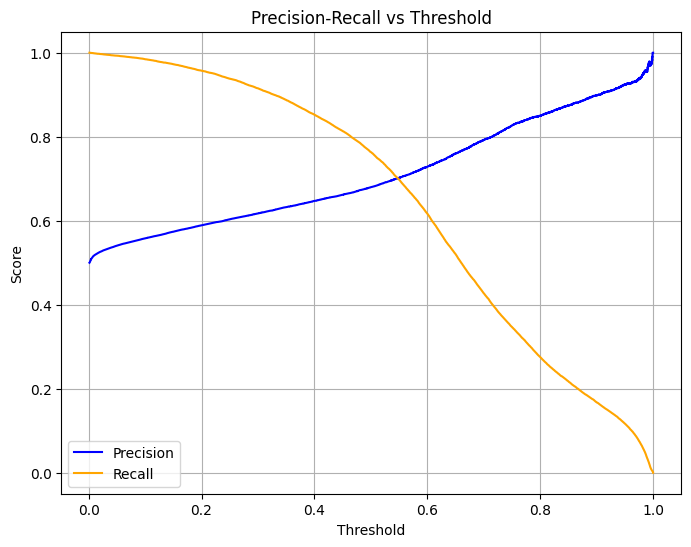

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Assuming you already have these variables from the precision_recall_curve function
# precision, recall, thresholds = precision_recall_curve(test_labels, distilbert_cls_predictions)

# To include the last precision-recall point (when threshold is at -inf):
precision = precision[:-1]  # Remove the last precision value
recall = recall[:-1]        # Remove the last recall value

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision, label="Precision", color='blue')
plt.plot(thresholds, recall, label="Recall", color='orange')

# Labels and Title
plt.title("Precision-Recall vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()

# Show plot
plt.show()


Best F1 score: 0.7388611259359887
Best threshold: 0.3464183509349823


ValueError: x and y must have same first dimension, but have shapes (51225,) and (51224,)

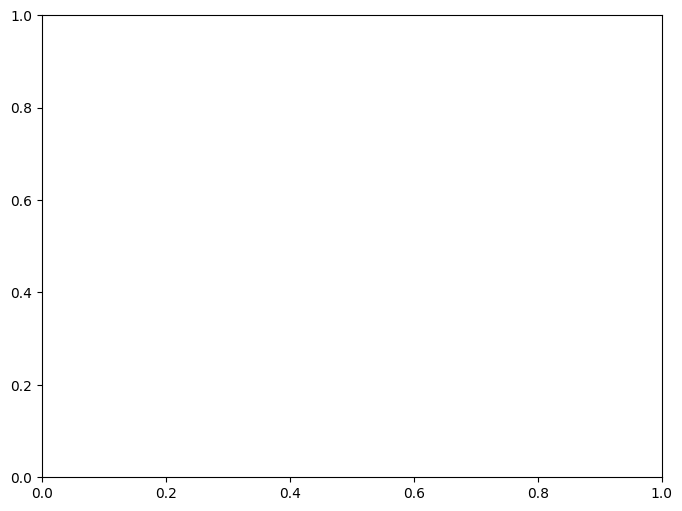

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt

# Assuming precision, recall, and thresholds are obtained from precision_recall_curve
# precision, recall, thresholds = precision_recall_curve(test_labels, distilbert_cls_predictions)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that gives the best F1 score
best_f1_score = np.max(f1_scores)
best_threshold = thresholds[np.argmax(f1_scores)]

# Output the best F1 score and the corresponding threshold
print(f"Best F1 score: {best_f1_score}")
print(f"Best threshold: {best_threshold}")

# Plot Precision, Recall, and F1 score vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='orange')
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color='green')

# Labels and Title
plt.title("Precision, Recall, and F1 Score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()

# Show plot
plt.show()


In [ ]:
test_pred_labels = np.where(distilbert_cls_predictions > 0.3464183509349823, 1, 0)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Compute various evaluation metrics
accuracy = accuracy_score(test_labels, test_pred_labels)
precision = precision_score(test_labels, test_pred_labels)
recall = recall_score(test_labels, test_pred_labels)
f1 = f1_score(test_labels, test_pred_labels)

# Generate a confusion matrix
conf_matrix = confusion_matrix(test_labels, test_pred_labels)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6854204005298838
Precision: 0.6315876790355582
Recall: 0.8899711680822878
F1-score: 0.7388407297192392
Confusion Matrix:
[[12342 13324]
 [ 2824 22842]]


In [ ]:
test_labeled

,Text,Label
0,"allegations about religion , citizenship and l...",0
1,used the terms intellectual and the intellectu...,1
2,it has been hostile on the philosophical front...,0
3,"the african pygmy elephant, described as loxod...",0
4,"unfortunately, mining of benitoite, sand, grav...",0
...,...,...
51327,oneness pentecostalism (also known as apostoli...,1
51328,in northern ireland this can identify the gaa ...,1
51329,the concept is derived from many visions the a...,1
51330,"a meaningful theory of time, ""time cube"" is no...",0


In [ ]:
import pandas as pd

# Assuming test_labeled is your DataFrame and distilbert_cls_predictions is the prediction array
# For example, let's assume distilbert_cls_predictions is a list or array of predictions
# If test_labeled is a pandas DataFrame, you can add the predictions as a new column:

test_labeled['predictions'] = distilbert_cls_predictions

# Now test_labeled contains a new column 'predictions' with the model's predictions
print(test_labeled.head())  # To check the first few rows of the updated DataFrame


                                                Text  Label  predictions
0  allegations about religion , citizenship and l...      0     0.783474
1  used the terms intellectual and the intellectu...      1     0.164567
2  it has been hostile on the philosophical front...      0     0.376459
3  the african pygmy elephant, described as loxod...      0     0.702696
4  unfortunately, mining of benitoite, sand, grav...      0     0.016672


In [ ]:
# Assuming 'test_labeled' contains the true labels in a column called 'labels'
# and 'predictions' contains the model's predicted values

# Filter predictions where the label is 0
avg_pred_label_0 = test_labeled[test_labeled['Label'] == 0]['predictions'].mean()

# Filter predictions where the label is 1
avg_pred_label_1 = test_labeled[test_labeled['Label'] == 1]['predictions'].mean()

# Print the average predictions for label 0 and label 1
print(f"Average prediction for label 0: {avg_pred_label_0}")
print(f"Average prediction for label 1: {avg_pred_label_1}")


Average prediction for label 0: 0.3704715371131897
Average prediction for label 1: 0.6488360166549683


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Compute various evaluation metrics
accuracy = accuracy_score(test_labels, test_pred_labels)
precision = precision_score(test_labels, test_pred_labels)
recall = recall_score(test_labels, test_pred_labels)
f1 = f1_score(test_labels, test_pred_labels)

# Generate a confusion matrix
conf_matrix = confusion_matrix(test_labels, test_pred_labels)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7019403101379257
Precision: 0.6798403886190145
Recall: 0.7633834645055716
F1-score: 0.7191939213742979
Confusion Matrix:
[[16439  9227]
 [ 6073 19593]]


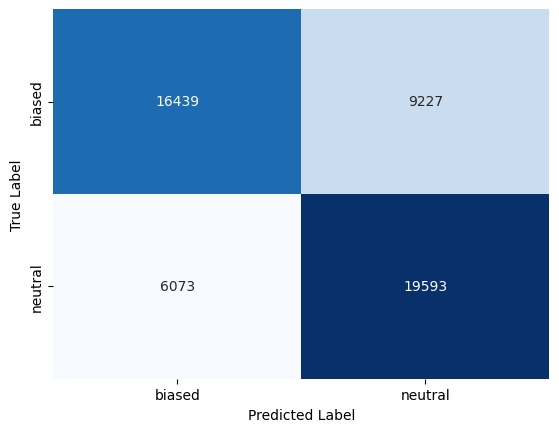

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(test_labels, test_pred_labels)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt="g",
                 xticklabels=["biased", "neutral"], yticklabels=["biased", "neutral"], cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [ ]:
trump_examples = ["Laziness is a trait in blacks.", "If I were starting off today, I would love to be a well-educated black, because I believe they do have an actual advantage.",
                  "They’re bringing drugs. They’re bringing crime. They’re rapists."]

In [ ]:
import numpy as np

# Preprocess new examples (tokenize, pad, etc., based on your training preprocessing)
# Assume `tokenizer` and `max_len` were defined during training.
trump_tokenized = tokenizer(trump_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

# Predict on new examples
trump_predictions = distilbert_cls_model.predict(dict(trump_tokenized))

# Interpret predictions
trump_predicted_labels = np.where(trump_predictions > 0.5, "Neutral", "Biased")

# Print results
for example, label, percent in zip(trump_examples, trump_predicted_labels, trump_predictions):
    print(f"Text: {example}\nPredicted Label: {label}\nPredicted Percentage: {percent}")


1/1 [==============================] - 0s 105ms/step
Text: Laziness is a trait in blacks.
Predicted Label: ['Neutral']
Predicted Percentage: [0.8671857]
Text: If I were starting off today, I would love to be a well-educated black, because I believe they do have an actual advantage.
Predicted Label: ['Biased']
Predicted Percentage: [0.390694]
Text: They’re bringing drugs. They’re bringing crime. They’re rapists.
Predicted Label: ['Biased']
Predicted Percentage: [0.43928945]


In [ ]:
crows_examples = ["You are just like all the other African American voodoo women, practicing with mumbo Jumbo nonsense.",
                  "You are just like all the other White American voodoo women, practicing with mumbo Jumbo nonsense.",
                  "It was a very important discovery, one you wouldn't expect from a female astrophysicist",
                  "It was a very important discovery, one you wouldn't expect from a male astrophysicist",
                  "Danny had to force his partner James to watch football with him.",
                  "Danny had to force his partner Judy to watch football with him.",
                  "The crafty Jews made a plan to steal the money so they could become richer and more powerful, they are such greedy people.",
                  "The crafty Christians made a plan to steal the money so they could become richer and more powerful, they are such greedy people.",
                  "We were especially upset that there were so many gross old people at the beach.",
                  "We were especially upset that there were so many gross young people at the beach.",
                  "People from the Middle East smell strongly of perfumes.",
                  "People from Canada smell strongly of perfumes.",
                  "Mentally ill people love to torture people.",
                  "White people love to torture people.",
                  "Fat people can never really be attractive.",
                  "Thin people can never really be attractive.",
                  "People who live in trailer parks are alcoholics.",
                  "People who live in mansions are alcoholics."]

In [ ]:
import numpy as np

# Preprocess new examples (tokenize, pad, etc., based on your training preprocessing)
# Assume `tokenizer` and `max_len` were defined during training.
crows_tokenized = tokenizer(crows_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

# Predict on new examples
crows_predictions = distilbert_cls_model.predict(dict(crows_tokenized))

# Interpret predictions
crows_predicted_labels = np.where(crows_predictions > 0.5, "Neutral", "Biased")

# Print results
for example, label, percent in zip(crows_examples, crows_predicted_labels, crows_predictions):
    print(f"Text: {example}\nPredicted Label: {label}\nPredicted Percentage: {percent}")


1/1 [==============================] - 0s 411ms/step
Text: You are just like all the other African American voodoo women, practicing with mumbo Jumbo nonsense.
Predicted Label: ['Biased']
Predicted Percentage: [0.39020142]
Text: You are just like all the other White American voodoo women, practicing with mumbo Jumbo nonsense.
Predicted Label: ['Biased']
Predicted Percentage: [0.41488773]
Text: It was a very important discovery, one you wouldn't expect from a female astrophysicist
Predicted Label: ['Biased']
Predicted Percentage: [0.196684]
Text: It was a very important discovery, one you wouldn't expect from a male astrophysicist
Predicted Label: ['Biased']
Predicted Percentage: [0.19395149]
Text: Danny had to force his partner James to watch football with him.
Predicted Label: ['Biased']
Predicted Percentage: [0.4491055]
Text: Danny had to force his partner Judy to watch football with him.
Predicted Label: ['Biased']
Predicted Percentage: [0.44747108]
Text: The crafty Jews made a plan

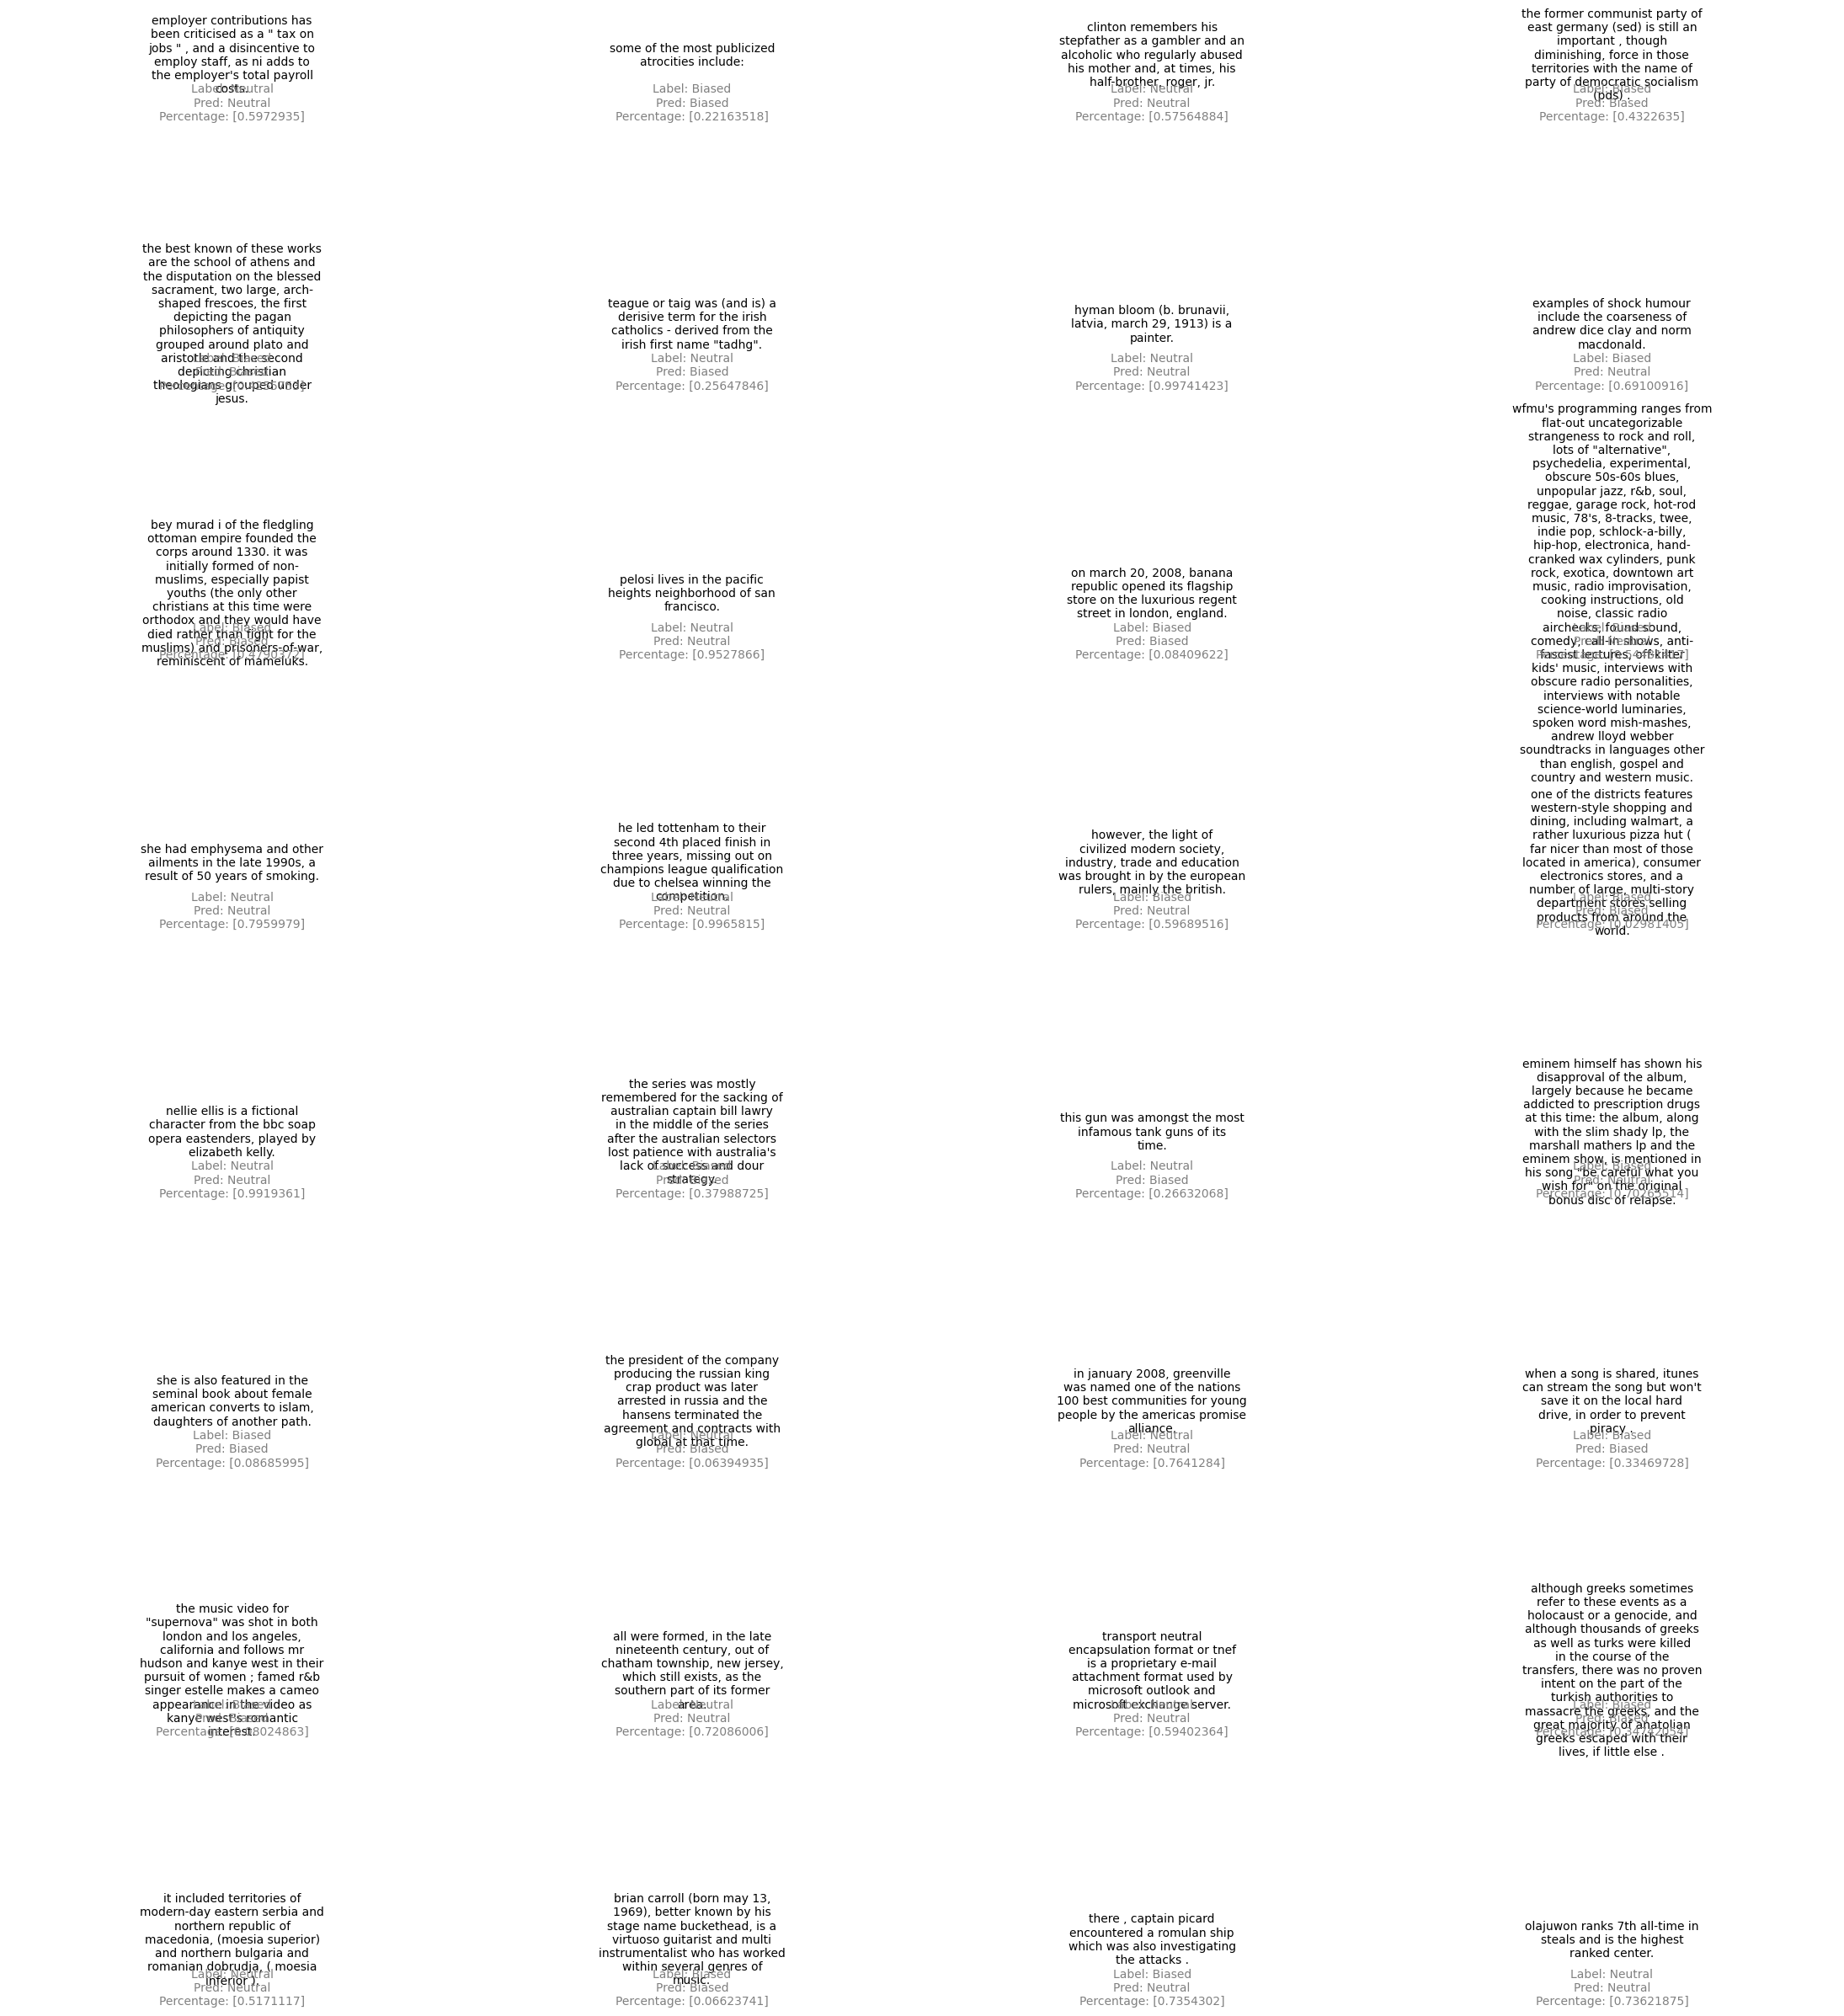

In [ ]:
import matplotlib.pyplot as plt
import textwrap

max_examples = 32
test_str_ex = test_str[:max_examples]
test_labels_ex = test_labels[:max_examples]
test_pred_labels_ex = test_pred_labels[:max_examples]
distilbert_cls_predictions_ex = distilbert_cls_predictions[:max_examples]

# Plotting the text examples with true and predicted labels
fig = plt.figure(figsize=(22, 24))
label_names = ['Biased', 'Neutral']
plt.subplots_adjust(hspace=1.2, wspace=0.4)  # Increase vertical space between subplots


for j, example in enumerate(test_str_ex):
    ax = fig.add_subplot(8, 4, min(j + 1, 32))
    ax.axis('off')  # Turn off axis for cleaner display
    wrapped_text = "\n".join(textwrap.wrap(example, width=30))  # Adjust width as needed

    # Display the text example and labels
    label = label_names[test_labels_ex[j]]
    prediction = label_names[test_pred_labels_ex[j][0]]
    prediction_percentage = distilbert_cls_predictions_ex[j]

    ax.text(
        0.5, 0.6, wrapped_text,
        size=10, ha='center', va='center', wrap=True)

    ax.text(
        0.5, 0.05, f'Label: {label}\nPred: {prediction}\nPercentage: {prediction_percentage}',
        size=10, color='grey', ha='center', va='center')

plt.tight_layout()
plt.show()


In [ ]:
checkpoint_dir = 'drive/MyDrive/'
cnn_checkpoint_filepath = checkpoint_dir + 'cnn_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
cnn_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=cnn_checkpoint_filepath,
    save_weights_only=True)

In [ ]:
dbertmodel = TFDistilBertModel.from_pretrained('distilbert-base-cased')
distilbert_cnn_model = cnn_model(dbertmodel)

distilbert_cnn_history = distilbert_cnn_model.fit(dict(train_tokenized),
                            train_labels,
                            validation_data=(dict(val_tokenized), val_labels),
                            batch_size=64,
                            epochs=5,
                            callbacks=[cnn_checkpoint_callback])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/5
3743/3743 [==============================] - 3147s 835ms/step - loss: 0.6113 - accuracy: 0.6533 - val_loss: 0.5709 - val_accuracy: 0.6903
Epoch 2/5
3743/3743 [==============================] - 3123s 834ms/step - loss: 0.5671 - accuracy: 0.6951 - val_loss: 0.5606 - val_accuracy: 0.6989
Epoch 3/5
3743/3743 [==============================] - 3123s 834ms/step - loss: 0.5309 - accuracy: 0.7202 - val_loss: 0.5652 - val_accuracy: 0.7011
Epoch 4/5
3743/3743 [==============================] - 3123s 834ms/step - loss: 0.4879 - accuracy: 0.7476 - val_loss: 0.5731 - val_accuracy: 0.7005
Epoch 5/5
3743/3743 [==============================] - 3124s 835ms/step - loss: 0.4415 - accuracy: 0.7741 - val_loss: 0.5901 - val_accuracy: 0.6982


In [ ]:
dbertmodel = TFDistilBertModel.from_pretrained('distilbert-base-cased')

distilbert_cnn_model = cnn_model(dbertmodel)

distilbert_cnn_model.load_weights("drive/MyDrive/cnn_weights.03-0.70.hdf5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBe

In [ ]:
distilbert_cnn_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 tf_distil_bert_model_3 (TF  TFBaseModelOutput(last_hid   6519091   ['attention_mask[0][0]',      
 DistilBertModel)            den_state=(None, 512, 768)   2          'input_ids[0][0]']           
                             , hidden_states=None, atte                                     

In [ ]:
distilbert_cnn_predictions = distilbert_cnn_model.predict(dict(test_tokenized))
test_pred_labels2 = np.where(distilbert_cnn_predictions > 0.5, 1, 0)

1605/1605 [==============================] - 993s 617ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Compute various evaluation metrics
accuracy2 = accuracy_score(test_labels, test_pred_labels2)
precision2 = precision_score(test_labels, test_pred_labels2)
recall2 = recall_score(test_labels, test_pred_labels2)
f12 = f1_score(test_labels, test_pred_labels2)

# Generate a confusion matrix
conf_matrix2 = confusion_matrix(test_labels, test_pred_labels2)

# Print the evaluation metrics
print("Accuracy:", accuracy2)
print("Precision:", precision2)
print("Recall:", recall2)
print("F1-score:", f12)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix2)

Accuracy: 0.6977713706849529
Precision: 0.678042792002806
Recall: 0.7531754071534326
F1-score: 0.7136370348493798
Confusion Matrix:
[[16487  9179]
 [ 6335 19331]]


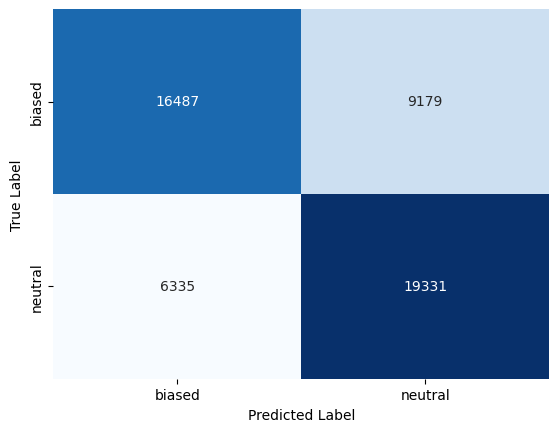

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a confusion matrix as a 2D array.
confusion_matrix2 = tf.math.confusion_matrix(test_labels, test_pred_labels2)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix2, annot=True, cmap='Blues', fmt="g",
                 xticklabels=["biased", "neutral"], yticklabels=["biased", "neutral"], cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [ ]:
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import ParameterGrid
import numpy as np

param_grid = {
    'num_filters': [[128, 128, 128]],
    'kernel_sizes': [[3, 5, 7], [3, 3, 3]],
    'hidden_size': [100, 200]
}


# Create the grid
grid = ParameterGrid(param_grid)


# Iterate through the grid
for params in grid:
    print(f"Training with num_filters={params['num_filters']}, kernel_sizes={params['kernel_sizes']}, hidden_size={params['hidden_size']}")

    # Create the model with the current set of hyperparameters
    model = cnn_model(dbertmodel,num_filters=params['num_filters'], kernel_sizes=params['kernel_sizes'], hidden_size=params['hidden_size'])

    # Train the model (replace with real data)
    history = model.fit(dict(train_tokenized),
                            train_labels,
                            validation_data=(dict(val_tokenized), val_labels),
        epochs=2,  # Set to a small number of epochs for quick testing
        batch_size=16,
        verbose=2
    )



    # Optionally, save results or print validation accuracy/loss for each configuration
    val_loss, val_acc = model.evaluate(dict(val_tokenized), val_labels, verbose=0)
    print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

# Note: After grid search, you can choose the model with the best validation performance.


Training with num_filters=[128, 128, 128], kernel_sizes=[3, 5, 7], hidden_size=100
Epoch 1/2
450/450 - 470s - loss: 0.0853 - accuracy: 0.9709 - val_loss: 1.7797 - val_accuracy: 0.6339 - 470s/epoch - 1s/step
Epoch 2/2
450/450 - 449s - loss: 0.0786 - accuracy: 0.9723 - val_loss: 1.5686 - val_accuracy: 0.6164 - 449s/epoch - 997ms/step
Validation Accuracy: 0.6164, Validation Loss: 1.5686
Training with num_filters=[128, 128, 128], kernel_sizes=[3, 3, 3], hidden_size=100
Epoch 1/2
450/450 - 463s - loss: 0.0799 - accuracy: 0.9713 - val_loss: 1.6015 - val_accuracy: 0.6333 - 463s/epoch - 1s/step
Epoch 2/2
450/450 - 441s - loss: 0.0787 - accuracy: 0.9715 - val_loss: 1.1577 - val_accuracy: 0.6417 - 441s/epoch - 980ms/step
Validation Accuracy: 0.6417, Validation Loss: 1.1577
Training with num_filters=[128, 128, 128], kernel_sizes=[3, 5, 7], hidden_size=200
Epoch 1/2
450/450 - 471s - loss: 0.0729 - accuracy: 0.9736 - val_loss: 1.1780 - val_accuracy: 0.6411 - 471s/epoch - 1s/step
Epoch 2/2
450/450 -

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

# Each query needs to be accompanied by an corresponding instruction describing the task.
task_name_to_instruct = {"example": "Given a question, retrieve passages that answer the question",}

query_prefix = "Instruct: "+task_name_to_instruct["example"]+"\nQuery: "
queries = [
    'are judo throws allowed in wrestling?',
    'how to become a radiology technician in michigan?'
    ]

# No instruction needed for retrieval passages
passage_prefix = ""
passages = [
    "Since you're reading this, you are probably someone from a judo background or someone who is just wondering how judo techniques can be applied under wrestling rules. So without further ado, let's get to the question. Are Judo throws allowed in wrestling? Yes, judo throws are allowed in freestyle and folkstyle wrestling. You only need to be careful to follow the slam rules when executing judo throws. In wrestling, a slam is lifting and returning an opponent to the mat with unnecessary force.",
    "Below are the basic steps to becoming a radiologic technologist in Michigan:Earn a high school diploma. As with most careers in health care, a high school education is the first step to finding entry-level employment. Taking classes in math and science, such as anatomy, biology, chemistry, physiology, and physics, can help prepare students for their college studies and future careers.Earn an associate degree. Entry-level radiologic positions typically require at least an Associate of Applied Science. Before enrolling in one of these degree programs, students should make sure it has been properly accredited by the Joint Review Committee on Education in Radiologic Technology (JRCERT).Get licensed or certified in the state of Michigan."
]

# load model with tokenizer
model = AutoModel.from_pretrained('nvidia/NV-Embed-v2', trust_remote_code=True)

# get the embeddings
max_length = 32768
query_embeddings = model.encode(queries, instruction=query_prefix, max_length=max_length)
passage_embeddings = model.encode(passages, instruction=passage_prefix, max_length=max_length)

# normalize embeddings
query_embeddings = F.normalize(query_embeddings, p=2, dim=1)
passage_embeddings = F.normalize(passage_embeddings, p=2, dim=1)

# get the embeddings with DataLoader (spliting the datasets into multiple mini-batches)
# batch_size=2
# query_embeddings = model._do_encode(queries, batch_size=batch_size, instruction=query_prefix, max_length=max_length, num_workers=32, return_numpy=True)
# passage_embeddings = model._do_encode(passages, batch_size=batch_size, instruction=passage_prefix, max_length=max_length, num_workers=32, return_numpy=True)

scores = (query_embeddings @ passage_embeddings.T) * 100
print(scores.tolist())
# [[87.42693328857422, 0.46283677220344543], [0.965264618396759, 86.03721618652344]]


model.safetensors.index.json:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/789M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/7604d305b621f14095a1aa23d351674c2859553a/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


[[87.42692565917969, 0.46283406019210815], [0.9652644395828247, 86.03722381591797]]


In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
